In [1]:
! git init
! git pull https://github.com/serzaraisk/noisy_labels.git

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 139 (delta 61), reused 114 (delta 36), pack-reused 0
Receiving objects: 100% (139/139), 4.63 MiB | 3.23 MiB/s, done.
Resolving deltas: 100% (61/61), done.
From https://github.com/serzaraisk/noisy_labels
 * branch            HEAD       -> FETCH_HEAD


## Step 0: Imports and Global variable init

In [2]:
! wget http://vectors.nlpl.eu/repository/20/213.zip -O fasttext.zip
! mkdir fast_text
! unzip fasttext.zip
! mv model.model fast_text
! mv model.model.vectors_ngrams.npy fast_text
! mv model.model.vectors.npy fast_text
! mv model.model.vectors_vocab.npy fast_text
! rm README
! rm meta.json

--2021-12-27 14:41:15--  http://vectors.nlpl.eu/repository/20/213.zip
Resolving vectors.nlpl.eu (vectors.nlpl.eu)... 129.240.189.181
Connecting to vectors.nlpl.eu (vectors.nlpl.eu)|129.240.189.181|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1485270300 (1.4G) [application/zip]
Saving to: ‘fasttext.zip’

fasttext.zip        100%[===================>]   1.38G  18.4MB/s    in 80s     

2021-12-27 14:42:35 (17.8 MB/s) - ‘fasttext.zip’ saved [1485270300/1485270300]

Archive:  fasttext.zip
  inflating: meta.json               
  inflating: model.model             
  inflating: model.model.vectors_ngrams.npy  
  inflating: model.model.vectors.npy  
  inflating: model.model.vectors_vocab.npy  
  inflating: README                  


In [3]:
! pip install gensim --upgrade

     |████████████████████████████████| 24.1 MB 1.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [4]:
! pip install pymorphy2

     |████████████████████████████████| 55 kB 3.2 MB/s 
     |████████████████████████████████| 8.2 MB 15.6 MB/s 


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [25]:
from torch import cuda
DEVICE = 'cuda' if cuda.is_available() else 'cpu'
DESTINATION_FOLDER = 'text_model/models'
DATASETS_FOLDER = 'data'
TRAIN_TEST_RATIO = 0.9
TRAIN_VALID_RATIO = 0.8

In [7]:
import torch.optim as optim
import torch.nn as nn
import torch

import text_model.prepare_dataset as prepare_dataset
import text_model.init_dataset_dataloader as init_dataset_dataloader
import text_model.model as model
import text_model.train_model as train_model
import text_model.evaluation as evaluation

## Step 1: Train_val_test_split data

In [106]:
#download dataset and filter language if needed
df = prepare_dataset.load_data('text_model/text_dataset.csv', filter_language=True)

# choose toloka column
df = prepare_dataset.choose_toloka_answer_column(df, 'aggr_answer')

# train_test_split dataset
prepare_dataset.train_test_split_df(df, 'data/', TRAIN_TEST_RATIO, TRAIN_VALID_RATIO)

## Step 2: Load Pytorch Dataset and dataloader

In [9]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [107]:
BATCH_SIZE = 32

train, valid, test, vocab = init_dataset_dataloader.create_dataset('data', 'float')
train_iter, valid_iter, test_iter = init_dataset_dataloader.create_iterators(train, valid, test, DEVICE, BATCH_SIZE)

## Step 3: Create model

In [108]:
fast_text_model = model.create_embed_model('fast_text/model.model')
weight_matrix = model.create_embed_matrix(vocab, fast_text_model)
model_cand = model.LSTM(weight_matrix, dimension=128, num_layers=2).to(DEVICE)

In [116]:
optimizer = optim.Adam(model_cand.parameters(), lr=0.01)
loss = nn.BCELoss().to(DEVICE)

## Step 5: Training

In [152]:
from importlib import reload
import text_model.mixup as train_model
reload(train_model)

<module 'text_model.train_model_2' from '/content/text_model/train_model_2.py'>

In [165]:
model_cand = model.LSTM(weight_matrix, dimension=128, num_layers=2).to(DEVICE)
optimizer = optim.Adam(model_cand.parameters(), lr=0.0001)
train_model.train(model=model_cand,
            model_name='mixup',   
            optimizer=optimizer, 
            device=DEVICE, 
            file_path=DESTINATION_FOLDER,  
            train_loader=train_iter,
            valid_loader=valid_iter, 
            num_epochs=10,
            criterion=loss
             )

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Step [180/3600], Train Loss: 0.3847, Valid Loss: 0.2955
Model saved to ==> text_model/models/mixup/model.pt
Model saved to ==> text_model/models/mixup/metrics.pt


 10%|█         | 1/10 [00:03<00:34,  3.86s/it]

Epoch [1/10], Step [360/3600], Train Loss: 0.3058, Valid Loss: 0.2731
Model saved to ==> text_model/models/mixup/model.pt
Model saved to ==> text_model/models/mixup/metrics.pt
Epoch [2/10], Step [540/3600], Train Loss: 0.2741, Valid Loss: 0.2728
Model saved to ==> text_model/models/mixup/model.pt
Model saved to ==> text_model/models/mixup/metrics.pt


 20%|██        | 2/10 [00:06<00:24,  3.06s/it]

Epoch [2/10], Step [720/3600], Train Loss: 0.2738, Valid Loss: 0.2566
Model saved to ==> text_model/models/mixup/model.pt
Model saved to ==> text_model/models/mixup/metrics.pt
Epoch [3/10], Step [900/3600], Train Loss: 0.2510, Valid Loss: 0.2669


 30%|███       | 3/10 [00:08<00:19,  2.78s/it]

Epoch [3/10], Step [1080/3600], Train Loss: 0.2411, Valid Loss: 0.2550
Model saved to ==> text_model/models/mixup/model.pt
Model saved to ==> text_model/models/mixup/metrics.pt
Epoch [4/10], Step [1260/3600], Train Loss: 0.2185, Valid Loss: 0.2701


 40%|████      | 4/10 [00:11<00:15,  2.61s/it]

Epoch [4/10], Step [1440/3600], Train Loss: 0.2285, Valid Loss: 0.2798
Epoch [5/10], Step [1620/3600], Train Loss: 0.1937, Valid Loss: 0.2654


 50%|█████     | 5/10 [00:13<00:12,  2.53s/it]

Epoch [5/10], Step [1800/3600], Train Loss: 0.2029, Valid Loss: 0.2614
Epoch [6/10], Step [1980/3600], Train Loss: 0.1734, Valid Loss: 0.3195


 60%|██████    | 6/10 [00:15<00:09,  2.49s/it]

Epoch [6/10], Step [2160/3600], Train Loss: 0.1677, Valid Loss: 0.3074
Epoch [7/10], Step [2340/3600], Train Loss: 0.1416, Valid Loss: 0.3321


 70%|███████   | 7/10 [00:18<00:07,  2.44s/it]

Epoch [7/10], Step [2520/3600], Train Loss: 0.1490, Valid Loss: 0.3176
Epoch [8/10], Step [2700/3600], Train Loss: 0.1125, Valid Loss: 0.3549


 80%|████████  | 8/10 [00:20<00:04,  2.41s/it]

Epoch [8/10], Step [2880/3600], Train Loss: 0.1339, Valid Loss: 0.3147
Epoch [9/10], Step [3060/3600], Train Loss: 0.0942, Valid Loss: 0.4323


 90%|█████████ | 9/10 [00:22<00:02,  2.39s/it]

Epoch [9/10], Step [3240/3600], Train Loss: 0.1026, Valid Loss: 0.4750
Epoch [10/10], Step [3420/3600], Train Loss: 0.0773, Valid Loss: 0.4753


100%|██████████| 10/10 [00:25<00:00,  2.54s/it]

Epoch [10/10], Step [3600/3600], Train Loss: 0.0984, Valid Loss: 0.4923
Model saved to ==> text_model/models/mixup/metrics.pt
Finished Training!


Model loaded from <== text_model/models/mixup/metrics.pt


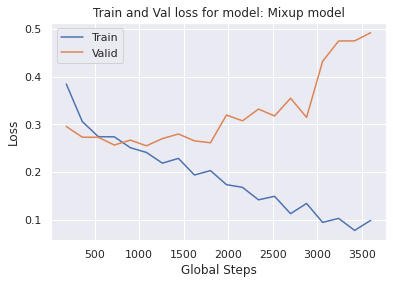

In [166]:
evaluation.plot_metrics(DESTINATION_FOLDER + '/mixup', 'Mixup model', DEVICE)  

## Step 6: Evaluation

Model loaded from <== text_model/models/mixup/model.pt
Classification Report for model Mixup_model:
              precision    recall  f1-score   support

           1     0.8588    0.5625    0.6798       400
           0     0.8666    0.9685    0.9147      1174

    accuracy                         0.8653      1574
   macro avg     0.8627    0.7655    0.7972      1574
weighted avg     0.8646    0.8653    0.8550      1574



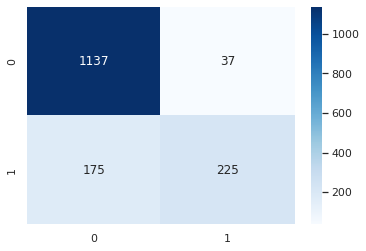

In [167]:
# Evaluation Function
evaluation.load_checkpoint(DESTINATION_FOLDER + '/mixup' + '/model.pt', model_cand, DEVICE)
_, _, roc_auc = evaluation.evaluate(model_cand, 'Mixup_model', test_iter, DEVICE)

In [168]:
roc_auc

0.7654919080068143